## Chemical kinetics
In chemistry one is often interested in how fast a chemical process proceeds. Chemical reactions (when viewed as single events on a molecular scale) are probabilitic. However, most reactive systems of interest involve very large numbers of molecules (a few grams of a simple substance containts on the order of $10^{23}$ molecules. The sheer number allows us to describe this inherently stochastic process deterministically.

### Law of mass action
In order to describe chemical reactions as as system of ODEs in terms of concentrations ($c_i$) and time ($t$), one can use the [law of mass action](https://en.wikipedia.org/wiki/Law_of_mass_action):

$$
\frac{dc_i}{dt} = \sum_j S_{ij} r_j
$$
where $r_j$ is given by:
$$
r_j = k_j\prod_l c_l^{R_{jl}}
$$

and $S$ is a matrix with the overall net stoichiometric coefficients (positive for net production, negative for net consumption), and $R$ is a matrix with the multiplicities of each reactant for each equation.

### Example: Nitrosylbromide
We will now look at the following (bi-directional) chemical reaction:

$$
\mathrm{2\,NO + Br_2 \leftrightarrow 2\,NOBr}
$$

which describes the equilibrium between nitrogen monoxide (NO) and bromine (Br$_2$) and nitrosyl bromide (NOBr). It can be represented as a set of two uni-directional reactions (**f**orward and **b**ackward):

$$
\mathrm{2\,NO + Br_2 \overset{k_f}{\rightarrow} 2\,NOBr} \\ 
\mathrm{2\,NOBr \overset{k_b}{\rightarrow} 2\,NO + Br_2}
$$

The law of mass action tells us that the rate of the first process (forward) is proportional to the concentration Br$_2$ and the square of the concentration of NO. The rate of the second reaction (the backward process) is in analogy proportional to the square of the concentration of NOBr. Using the proportionality constants $k_f$ and $k_b$ we can formulate our system of nonlinear ordinary differential equations as follows:

$$
\frac{dc_1}{dt} = 2(k_b c_3^2 - k_f c_2 c_1^2) \\
\frac{dc_2}{dt} = k_b c_3^2 - k_f c_2 c_1^2 \\
\frac{dc_3}{dt} = 2(k_f c_2 c_1^2 - k_b c_3^2)
$$

where we have denoted the concentration of NO, Br$_2$, NOBr with $c_1,\ c_2,\ c_3$ respectively.

This ODE system corresponds to the following two matrices:

$$
S = \begin{bmatrix}
-2 & 2 \\
-1 & 1 \\
2 & -2
\end{bmatrix}
$$

$$
R = \begin{bmatrix}
2 & 1 & 0 \\
0 & 0 & 2 
\end{bmatrix}
$$


### Solving the initial value problem numerically
We will now integrate this system of ordinary differential equations numerically as an initial value problem (IVP) using the ``odeint`` solver provided by ``scipy``:

In [1]:
import numpy as np
from scipy.integrate import odeint

By looking at the [documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.integrate.odeint.html) of odeint we see that we need to provide a function which computes a vector of derivatives ($\dot{\mathbf{y}} = [\frac{dy_1}{dt}, \frac{dy_2}{dt}, \frac{dy_3}{dt}]$). The expected signature of this function is:

    f(y: array[float64], t: float64, *args: arbitrary constants) -> dydt: array[float64]
    
in our case we can write it as:

In [2]:
def rhs(y, t, kf, kb):
    rf = kf * y[0]**2 * y[1]
    rb = kb * y[2]**2
    return [2*(rb - rf), rb - rf, 2*(rf - rb)]

In [3]:
%load_ext scipy2017codegen.exercise

Replace **???** by the proper arguments for ``odeint``, you can write ``odeint?`` to read its documentaiton.

In [4]:
# %exercise exercise_odeint.py
tout = np.linspace(0, 10)
k_vals = 0.42, 0.17  # arbitrary in this case
y0 = [1, 1, 0]
yout = odeint(rhs, y0, tout, k_vals)  # EXERCISE: rhs, y0, tout, k_vals

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

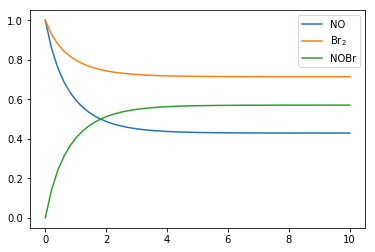

In [6]:
plt.plot(tout, yout)
_ = plt.legend(['NO', 'Br$_2$', 'NOBr'])

Writing the ``rhs`` function by hand for larger reaction systems quickly becomes tedious. Ideally we would like to construct it from a symbolic representation (having a symbolic representation of the problem opens up many possibilities as we will soon see). But at the same time, we need the ``rhs`` function to be fast. Which means that we want to produce a fast function from our symbolic representation. Generating a function from our symbolic representation is achieved through *code generation*. 

In summary we will need to:

1. Construct a symbolic representation from some domain specific representation using SymPy.
2. Have SymPy generate a function with an appropriate signature (or multiple thereof), which we pass on to the solver.

We will achieve (1) by using SymPy symbols (and functions if needed). For (2) we will use a function in SymPy called ``lambdify``―it takes a symbolic expressions and returns a function. In a later notebook, we will look at (1), for now we will just use ``rhs`` which we've already written:

In [7]:
import sympy as sym
sym.init_printing()

In [8]:
y, k = sym.symbols('y:3'), sym.symbols('kf kb')
ydot = rhs(y, None, *k)
ydot

## Exercise
Now assume that we had constructed ``ydot`` above by applying the more general law of mass action, instead of hard-coding the rate expressions in ``rhs``. Then we could have created a function corresponding to ``rhs`` using ``lambdify``:

In [9]:
# %exercise exercise_lambdify.py
t = sym.symbols('t')  # not used in this case.
f = sym.lambdify((y, t) + k, ydot)  # EXERCISE: (y, t) + k

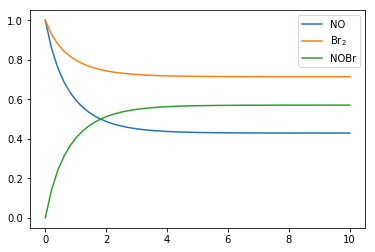

In [10]:
plt.plot(tout, odeint(f, y0, tout, k_vals))
_ = plt.legend(['NO', 'Br$_2$', 'NOBr'])

In this example the gains of using a symbolic representation are arguably limited. However, it is quite common that the numerical solver will need another function which calculates the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) of $\dot{\mathbf{y}}$ (given as Dfun in the case of ``odeint``). Writing that by hand is both tedious and error prone. But SymPy solves both of those issues:

In [11]:
sym.Matrix(ydot).jacobian(y)

⎡                     2          ⎤
⎢-4⋅kf⋅y₀⋅y₁  -2⋅kf⋅y₀   4⋅kb⋅y₂ ⎥
⎢                                ⎥
⎢                    2           ⎥
⎢-2⋅kf⋅y₀⋅y₁   -kf⋅y₀    2⋅kb⋅y₂ ⎥
⎢                                ⎥
⎢                    2           ⎥
⎣4⋅kf⋅y₀⋅y₁   2⋅kf⋅y₀    -4⋅kb⋅y₂⎦

In the next notebook we will look at an example where providing this as a function is beneficial for performance.